### Differential Equation

$\frac{\mathrm{d}\Psi}{\mathrm{d}x} = -(x + \frac{1 + 3x^2}{1 + x + x^3})\Psi + x^3 + 2x + x^2 \frac{1 + 3x^2}{1 + x + x^3},$

$\Psi(0) = 1, x \in [0, 2]$

In [103]:
from typing import List, Tuple, Callable
import autograd.numpy as np
from autograd import grad, elementwise_grad
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [71]:
PSI_0 = np.array([1])

def derivative(x, psi) -> np.ndarray:
    """Example #1 derivative.
    
    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_dot = -(x + (1 + 3 * x**2) / (1 + x + x**3)) * psi + x**3 + 2 * x + x**2 * (1 + 3 * x**2) / (1 + x + x**3)
    return psi_dot

def analytical_solution(x):
   """Analytical solution to example #1.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
   return np.exp(-x**2 / 2) / (1 + x + x**3) + x**2

### Activation Functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def elu(z, alpha: float):
    return alpha * (np.exp(z) - 1) if z < 0 else z

### Neural Network

![](NN.png "Neural Network")

In [122]:
class NeuralNetwork:
    """A neural network class for solving ODEs or system of ODEs.
        Attributes:
            init_conditions (np.array): Initial conditions for the target function.
            derivative (Callable): Function that calculates the target derivative of the neural network.
            input_size (int): Size of the input layer.
            hidden_sizes (np.array): Array of integers representing the sizes of the hidden layers.
            output_size (int): Size of the output layer.
            activation_fns (List[Callable]): List of activation functions for each layer.
            weights (List[np.array]): List of weights and biases for each layer.

        Methods:
            init_weights(): Initializes the weights and biases of the neural network.
            forward(t: np.array, weights: List[np.array]) -> np.array: Makes a forward pass through the neural network.
            mse_loss_function(t: np.array, weights: List[np.array]) -> float: Calculates the mean squared error of the neural network.
            trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution.
            trial_grad(t: np.array, weights: List[np.array]) -> np.array: Calculates the gradient of the trial solution with respect to t.
            gradient_descent(t: np.array, num_iter: int, learn_rate: float) -> List[np.array]: Runs gradient descent for a given number of iterations.
    """
    def __init__(self, init_conditions: np.array, derivative: Callable, input_size: int, hidden_sizes: np.array, output_size: int, activation_fns: List[Callable]):
        self.init_conditions = init_conditions
        self.derivative = derivative
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_fns = activation_fns
        self.weights = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output
        self.init_weights()

    def init_weights(self):
        """ Initializes the weights and biases of the neural network 
        Args:
            None
        
        Returns:
            None
        """
        # hidden weights and biases
        self.weights[0] = np.random.randn(self.hidden_sizes[0], self.input_size + 1) # +1 for the bias
        for i in range(1, self.hidden_sizes.shape[0]):
            self.weights[i] = np.random.randn(self.hidden_sizes[i], self.hidden_sizes[i - 1] + 1) # +1 for the bias

        # output weights and biases
        self.weights[-1] = np.random.randn(self.output_size, self.hidden_sizes[-1] + 1) # +1 for the bias

    def forward(self, t: np.array, weights: List[np.array]) -> np.array:
        """Makes a forward pass through the neural network.

        Args:
            t: The t vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the output of the neural network of dim(3, len(t)).
        """
        num_layers = len(weights)
        # row matrix
        t = t.reshape(-1, t.size)

        z = None
        a = t
        for i in range(num_layers):
            z = np.matmul(weights[i], np.concatenate((np.ones((1, t.size)), a), axis = 0))
            a = self.activation_fns[i](z)
        
        return z

    def mse_loss_function(self, t: np.array, weights: List[np.array]) -> float:
        """Calculates the mean squared error of the neural network.

        Args:
            t: The input vector
            weights: The weights and biases of the neural network

        Returns:
            Mean squared error value
        
        """
        trial_sol = self.trial_solution(t, weights)
        grad_star = self.derivative(t, trial_sol)
        grad = self.trial_grad(t, weights)
        error = grad_star - grad

        print(trial_sol.shape)
        print(grad_star.shape)
        print(grad.shape)
        print(error.shape)

        return np.linalg.norm(error, 'fro') / np.sqrt(np.size(error))

    def trial_solution(self, t: np.array, weights: List[np.array]) -> np.ndarray:
        """Calculates the trial solution of the system of ODEs.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the trial solution of the system of ODEs
            dimension (self.output_size, len(t))
        """
        fp = self.forward(t, weights)
        return np.array([self.init_conditions[i] + t * fp[i] for i in range(self.output_size)])

    def elementwise_trial_solution(self, t: np.array, weights: List[np.array], index):
        return self.trial_solution(t, weights)[index]

    def trial_grad(self, t: np.array, weights: List[np.array]) -> np.array:
        """Calculates the gradient of the trial solution of the Lorentz System.
        
        Args:
            t: The input vector
            weights: The weights and biases of the neural network
        
        Returns:
            A NumPy array of the gradient of the trial solution of the Lorentz System with 
            dimension (self.output_size, len(t))
        """
        return np.array([elementwise_grad(self.elementwise_trial_solution, 0)(t, weights, i) for i in range(self.output_size)])

    def gradient_descent(self, t: np.array, num_iter: int, learn_rate: float):
        """Runs gradient descent for a given number of iterations

        Args:
            t: The input vector
            num_iter: The number of iterations
            learn_rate: The learning rate
        
        Returns:
            weights: The weights and biases of the neural network after gradient descent
        """
        loss_grad_function = grad(self.mse_loss_function, 1)

        for i in range(num_iter):
            print("iteration: ", i)
            print(self.mse_loss_function(t, self.weights))
            loss_grad = loss_grad_function(t, self.weights)
            
            for j in range(len(self.weights)):
                self.weights[j] = self.weights[j] - learn_rate * loss_grad[j]

        return self.weights
    
    def adam(self, t, grad, num_iters=10000, step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
        loss_grad_function = grad(self.mse_loss_function, 1)

        m = [np.zeros_like(self.weights[i]) for i in range(len(self.weights))]
        v = [np.zeros_like(self.weights[i]) for i in range(len(self.weights))]
        mhat = [None] * len(self.weights)
        vhat = [None] * len(self.weights)
        for i in range(num_iters):
            g = loss_grad_function(t, self.weights)
            print("iteration: ", i)
            print(self.mse_loss_function(t, self.weights))
            
            for j in range(len(self.weights)):
                m[j] = (1 - b1) * g[j]      + b1 * m[j]  # First  moment estimate.
                v[j] = (1 - b2) * (g[j]**2) + b2 * v[j]  # Second moment estimate.
                mhat[j] = m[j] / (1 - b1**(i + 1))    # Bias correction.
                vhat[j] = v[j] / (1 - b2**(i + 1)) 
                self.weights[j] = self.weights[j] - step_size * mhat[j]/(np.sqrt(vhat[j]) + eps)
        
        return self.weights

### Training

In [123]:
def train(init_conditions):
    t = np.arange(0, 2, 0.01)
    hidden_sizes = np.array([10])
    activation_fns = [sigmoid] * (len(hidden_sizes)) + [lambda x: x]
    nn = NeuralNetwork(init_conditions, derivative, 1, hidden_sizes, 1, activation_fns)
    nn.gradient_descent(t, 1, 0.0001)

    return nn

nn = train(PSI_0)

iteration:  0
(1, 200)
(1, 200)
(1, 200)
(1, 200)
3.412394965595225
(1, 200)
(1, 200)
(1, 200)
(1, 200)


### Evaluating Results

In [120]:
def plot(neural_network: NeuralNetwork, scale=1, dt=0.1):
   t = np.arange(0, 2, dt)
   res = neural_network.trial_solution(t, neural_network.weights)
   fig = plt.figure(figsize=(10, 10))
   ax = fig.add_subplot()
   ax.plot(t, res[0], lw=1)
   ax.plot(t, analytical_solution(t), lw=1)
   plt.legend(['nn', 'analytical'])

   print(analytical_solution(t) - res[0])

def simulate_sode(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
   """Simulate the system of ODEs over the time interval [0, dt * num_steps].

   Args:
      dt: The t step
      initial_conditions: The initial conditions
      num_steps: The number of t steps to calculate
   
   Returns:
      A tuple of two NumPy arrays: the function output values, and the derivatives.
   """
   df_dt = np.empty((len(t), len(initial_conditions)))
   output = np.empty((len(t), len(initial_conditions)))
   output[0] = initial_conditions

   for i in range(len(t) - 1):
      dt = t[i + 1] - t[i]
      output[i + 1] = output[i] + derivative(t[i], output[i]) * dt
      df_dt[i] = derivative(t[i], output[i])
   
   return output, df_dt

[ 0.         -0.00312869 -0.00416887 -0.00563695 -0.00817624 -0.01140987
 -0.01461278 -0.01722498 -0.01913393 -0.02068281 -0.02244658 -0.02490097
 -0.02814924 -0.0318466  -0.03537318 -0.03818419 -0.04016172 -0.04175842
 -0.04377719 -0.04676303]


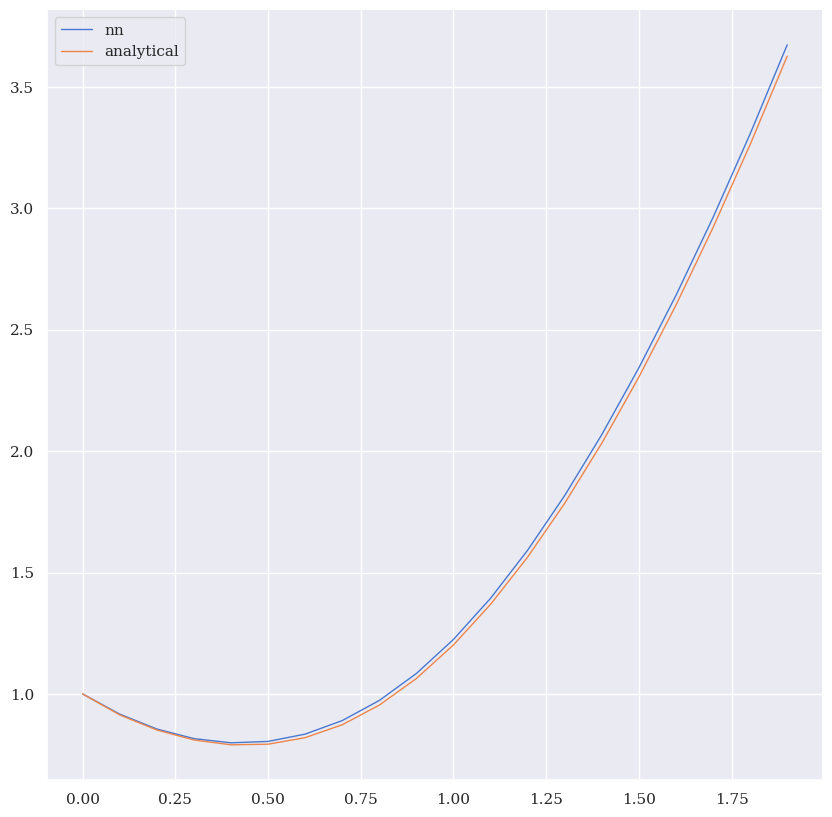

In [121]:
sns.set_theme(style="darkgrid", palette="muted", font='DeJavu Serif')
plot(nn)
sns.despine()